# 목적
* 파라미터 효율적 방식의 LLM 파인튜닝 노트 정리

## dir settings

In [1]:
import os 
import sys 
PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

for path in [PROJECT_DIR]: 
    if path not in sys.path:
        sys.path.append(path)

from src.configs.config_logs import setup_root_logger, setup_logger

logger = setup_root_logger('peft-notebook', project_root_dir=PROJECT_DIR)

## packges

In [2]:
# GPU 메모리 효율적 사용을 위해 가장 작은 메모리 단위를 64MB로 설정 (trial-and-error로 조정 가능)
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:64'

from huggingface_hub import login 
import torch 
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import Dataset, DatasetDict
from peft import LoraConfig 
from trl import SFTConfig, SFTTrainer 

import gdown
import json 

import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from src.utils.multi import count_languages, filter_non_english_samples_mp

/miniconda/envs/aifrenz/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-07 05:37:00,383 - datasets - INFO - [config.py:54] - PyTorch version 2.7.1 available.


In [3]:
import trl 
trl.__version__

'0.19.0'

## constants

In [4]:
# MODEL_NAME = 'skt/A.X-4.0-Light'
MODEL_NAME = "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"

CONTENT_DIR = os.path.join(PROJECT_DIR, 'content') 
DATA_DIR = os.path.join(CONTENT_DIR, "data")
os.makedirs(DATA_DIR, exist_ok=True)

MODEL_DIR = os.path.join(CONTENT_DIR, 'model') 
RESULTS_DIR = os.path.join(MODEL_DIR, 'results')

# Hugging Face API 키를 환경 변수에서 가져오기
# 키는 json 파일에 
# {"hf_token": "your_huggingface_token_here"}
# 형식으로 저장되어 있어야 합니다.
API_KEYS = json.load(open(os.path.join(PROJECT_DIR, ".env", "secret.json"), "r"))

# configs 

In [5]:
torch.manual_seed(42)

In [6]:
# 모델 접근 권한이 부여된 토큰
# 한번 로그인하면 이후 ~/.cache/huggingface/token 파일에 저장됨
login(API_KEYS["HF_TOKEN"])

## utils

In [7]:
def download_guanco_dataset(output_eva, output_train): 
    url_eva = 'https://drive.google.com/uc?id=1PFLTYBJi0rLQlFjWrr8ioaIgoNbiffXx&confirm=t'
    url_train = 'https://drive.google.com/uc?id=1tAJI0z_dyZAX9MW6tYmv3znH_561BDVY&confirm=t'

    if not os.path.exists(output_eva):
        gdown.download(url_eva, output_eva, quiet=False, proxy=None)
    if not os.path.exists(output_train):
        gdown.download(url_train, output_train, quiet=False, proxy=None)

In [8]:
def generate_response(model, tokenizer, messages, max_length=1024):
    input_ids = tokenizer.apply_chat_template(
        messages, 
        add_generation_prompt=True, 
        return_tensors="pt").to(model.device)

    len_input_prompt = len(input_ids[0])
    
    with torch.no_grad():
        output = model.generate(
            input_ids=input_ids,
            max_new_tokens=max_length,
            do_sample=True,
            temperature=0.7,
            top_p=0.95,
            top_k=50,
            repetition_penalty=1.2,
        )
    
    response = tokenizer.decode(output[0][len_input_prompt:], skip_special_tokens=True)
    return response

In [9]:
def transform_to_template(example, add_generation_prompt=False):
    """
    HF Dataset의 'text' 필드에 저장된 원본 대화(### 구분, Human/Assistant 태그 포함)를
    다음 Jinja 템플릿과 동일한 출력 형식으로 변환합니다.

    "{% for message in messages %}
        {% if loop.first and message['role'] != 'system' %}[|system|][|endofturn|]\n{% endif %}
        [|{{ message['role'] }}|]{{ message['content'] }}{% if message['role'] == 'user' %}\n{% else %}[|endofturn|]\n{% endif %}
     {% endfor %}
     {% if add_generation_prompt %}[|assistant|]{% endif %}"
    """
    conversation_text = example["text"]
    segments = conversation_text.split("###")

    # 1) 'segments'를 role‧content 쌍의 리스트로 재구성
    messages = []
    for i in range(1, len(segments) - 1, 2):
        user_msg = segments[i].strip().replace("Human:", "").strip()
        messages.append({"role": "user", "content": user_msg})

        if i + 1 < len(segments):
            assistant_msg = segments[i + 1].strip().replace("Assistant:", "").strip()
            messages.append({"role": "assistant", "content": assistant_msg})

    # 2) 템플릿 규칙에 따라 최종 문자열 빌드
    output_lines = []
    if messages and messages[0]["role"] != "system":
        output_lines.append("[|system|][|endofturn|]")

    for msg in messages:
        role, content = msg["role"], msg["content"]
        if role == "user":
            # 사용자 메시지는 줄바꿈만
            output_lines.append(f"[|{role}|]{content}\n")
        else:
            # assistant‧system 메시지는 [|endofturn|] 태그와 줄바꿈
            output_lines.append(f"[|{role}|]{content}[|endofturn|]\n")

    # 3) 필요 시 마지막에 generation 프롬프트 추가
    if add_generation_prompt:
        output_lines.append("[|assistant|]")

    return {"text": "".join(output_lines)}

# data 

In [10]:
# 데이터 경로 설정
train_path = os.path.join(DATA_DIR, 'openassistant_best_replies_train.jsonl')
test_path = os.path.join(DATA_DIR, 'openassistant_best_replies_eval.jsonl')

# 데이터 다운로드
download_guanco_dataset(
    output_eva=test_path, 
    output_train=train_path)

In [11]:
logger.info(f"{os.path.isfile(train_path)}: {train_path}")
logger.info(f"{os.path.isfile(test_path)}: {test_path}")

2025-07-07 05:37:01,691 - root - INFO - [2607186663.py:1] - True: /home/whlee/2_notepad/aifrenz2025/content/data/openassistant_best_replies_train.jsonl
2025-07-07 05:37:01,691 - root - INFO - [2607186663.py:2] - True: /home/whlee/2_notepad/aifrenz2025/content/data/openassistant_best_replies_eval.jsonl


In [12]:
with open(train_path, 'r') as f:
    raw_train_data = [json.loads(line) for line in f]

with open(test_path, 'r') as f:
    raw_test_data = [json.loads(line) for line in f]

In [13]:
raw_train_data[:3]

[{'text': '### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining p

In [14]:
raw_test_data[:3]

[{'text': '### Human: Напиши функцию на языке swift, которая сортирует массив целых чисел, а затем выводит его на экран### Assistant: Вот функция, которая сортирует массив целых чисел и выводит его на экран:\n\n```swift\nfunc sortAndPrintArray(_ array: [Int]) {\n  // Создаем копию массива, чтобы не изменять исходный\n  var sortedArray = array\n  // Сортируем массив по возрастанию\n  sortedArray.sort()\n  // Выводим отсортированный массив на экран\n  print(sortedArray)\n}\n```\n\n\nТы можешь проверить работу функции, вызвав ее с любым массивом целых чисел, например:\n\n```swift\nsortAndPrintArray([5, 2, 7, 9, -3])\n```\n\nНа экране появится:\n\n```sh\n[-3, 2, 5, 7, 9]\n```\n---\nНадеюсь, что я смог тебе помочь. Нужно ли тебе что-нибудь ещё? 😊'},
 {'text': '### Human: Inventa un monstruo altamente complejo, descríbelo y enumera sus ventajas y desventajas ante el ambiente en el que se supone que se debe de encontrar.### Assistant: Aquí te presento mi creación de un monstruo altamente comp

In [15]:
len(raw_train_data), len(raw_test_data)

(9846, 518)

100%|██████████| 10364/10364 [00:03<00:00, 3279.08it/s]


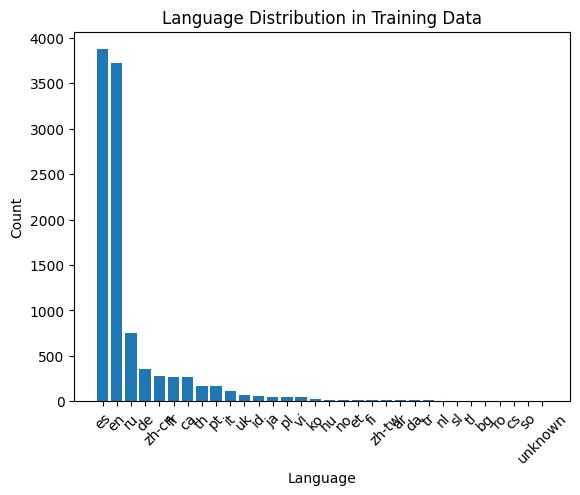

In [16]:
lang_cnt_dict = count_languages(raw_train_data, raw_test_data, n_workers=20)

lang_cnt_dict = dict(sorted(lang_cnt_dict.items(), key=lambda item: item[1], reverse=True))

plt.bar(lang_cnt_dict.keys(), lang_cnt_dict.values())
plt.xlabel("Language")
plt.ylabel("Count")
plt.title("Language Distribution in Training Data")
plt.xticks(rotation=45)
plt.show()


In [17]:
filtered_train_data = filter_non_english_samples_mp(raw_train_data, is_tqdm=True)
filtered_test_data = filter_non_english_samples_mp(raw_test_data, is_tqdm=True)

100%|██████████| 518/518 [00:01<00:00, 306.11it/s]


In [18]:
len(filtered_train_data), len(filtered_test_data)

(3542, 191)

In [19]:
# 커스텀 json 데이터를 DatasetDict 형태로 변환
train_ds = Dataset.from_list(filtered_train_data)
test_ds  = Dataset.from_list(filtered_test_data)

dataset = DatasetDict({
    "train": train_ds,
    "test":  test_ds
})

del train_ds, test_ds

In [20]:
template_dataset = dataset.map(transform_to_template)

Map: 100%|██████████| 191/191 [00:00<00:00, 28608.08 examples/s]


# model 

In [21]:
model_name = MODEL_NAME

In [22]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
)

model.eval() 
'Done'

2025-07-07 05:37:14,768 - accelerate.utils.modeling - INFO - [modeling.py:991] - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


'Done'

In [23]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [24]:
tokenizer.get_chat_template()

"{% for message in messages %}{% if loop.first and message['role'] != 'system' %}{{ '[|system|][|endofturn|]\n' }}{% endif %}{{ '[|' + message['role'] + '|]' + message['content'] }}{% if message['role'] == 'user' %}{{ '\n' }}{% else %}{{ '[|endofturn|]\n' }}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ '[|assistant|]' }}{% endif %}"

## PEFT 방식 파인튜닝

In [25]:
lora_config = LoraConfig(
    lora_alpha=16,      # LoRA 스케일링 계수. 실제 가중치에 적용되는 스케일은 lora_alpha / r 입니다.
    lora_dropout=0.1,   # LoRA 적용 전 투입되는 드롭아웃 확률
    r=64,               # LoRA의 rank(저차원 행렬 차원). 값이 클수록 표현력이 높지만 파라미터 수도 증가
    bias="none",        # LoRA 외의 bias 학습 범위: "none" | "all" | "lora_only"
    task_type="CAUSAL_LM",  # 적용 대상 작업 유형. GPT류 언어 모델은 일반적으로 "CAUSAL_LM"
    target_modules="all-linear"  # LoRA를 적용할 모듈. "all-linear"는 모든 선형 계층에 적용
)

In [26]:
# # 추론 과정에서 일부 레이어를 역양자화 하고, 연산 후 메모리에서 즉시 해제하여 효율적으로 GPU 메모리 사용
# quant_config = BitsAndBytesConfig(
#     load_in_4bit=True,          # 모델 가중치를 4-bit로 로드
#     bnb_4bit_quant_type="nf4",  # 4-bit 양자화 방식: 비대칭 분포를 갖는 NF4(NormalFloat4)
#     bnb_4bit_compute_dtype=torch.float16,  # matmul·attention 연산을 FP16으로 수행
#     bnb_4bit_use_double_quant=False,       # 8-bit→4-bit 이중 양자화(더 작은 지표 스케일) 비활성화
# )

* [https://docs.predibase.com/sdk-reference/configuration/sft-config](https://docs.predibase.com/sdk-reference/configuration/sft-config)

In [27]:
sft_config = SFTConfig(
    dataset_text_field="text",  # DatasetDict에서 사용할 텍스트 필드
    max_seq_length=256, # 최대 시퀀스 길이

    num_train_epochs=3, 
    per_device_train_batch_size=16, 
    gradient_accumulation_steps=1,  # 배치 크기를 늘리기 위한 그래디언트 누적 단계 

    optim="paged_adamw_32bit", 
    learning_rate=2e-4,  # 학습률
    weight_decay=0.001,  # 가중치 감쇠 
    lr_scheduler_type="cosine_with_restarts",  # 학습률 스케줄러
    warmup_ratio=0.03,  # 워밍업 비율
    max_grad_norm=.3, 

    bf16=False, 
    fp16=False, 
    save_steps=25, 
    logging_steps=1, 

    output_dir=RESULTS_DIR, 

    save_total_limit=3, 
    run_name=None, 
    report_to=["tensorboard"], 

    packing=False, 
    eval_packing=False, 
)

In [28]:
trainer = SFTTrainer(
    model=model,
    train_dataset=template_dataset["train"],
    eval_dataset=template_dataset["test"],
    peft_config=lora_config,
    args=sft_config,
    processing_class=tokenizer,
)

Truncating eval dataset: 100%|██████████| 191/191 [00:00<00:00, 125017.49 examples/s]
2025-07-07 05:37:21,947 - accelerate.utils.other - WARNING - [other.py:492] - Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [29]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
logger.info(f"Number of trainable parameters: {num_trainable_params / 1e6:.2f}M")

num_params = sum(p.numel() for p in model.parameters())
logger.info(f"Total number of parameters: {num_params / 1e6:.2f}M")

2025-07-07 05:37:21,995 - root - INFO - [2063472140.py:2] - Number of trainable parameters: 87.98M
2025-07-07 05:37:21,998 - root - INFO - [2063472140.py:5] - Total number of parameters: 2493.31M


In [30]:
trainer.train()

Step,Training Loss
1,3.531200
2,3.656200
3,3.062500
4,3.453100
5,3.000000
6,3.640600
7,3.390600
8,3.171900
9,2.687500
10,3.203100


TrainOutput(global_step=666, training_loss=1.269824512012012, metrics={'train_runtime': 544.6397, 'train_samples_per_second': 19.51, 'train_steps_per_second': 1.223, 'total_flos': 3.641604705091584e+16, 'train_loss': 1.269824512012012})